In [ ]:
!pip install torch torchvision mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 13.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
   creating: data/train/Fine/
  inflating: data/train/Fine/1715432224001.jpg  
  inflating: data/train/Fine/1715432224001_darker.jpg  
  inflating: data/train/Fine/1715432224001_lighter.jpg  
  inflating: data/train/Fine/1715432224011.jpg  
  inflating: data/train/Fine/1715432224011_darker.jpg  
  inflating: data/train/Fine/1715432224011_lighter.jpg  
  inflating: data/train/Fine/1715432224021.jpg  
  inflating: data/train/Fine/1715432224021_darker.jpg  
  inflating: data/train/Fine/1715432224021_lighter.jpg  
  inflating: data/train/Fine/1715432224031.jpg  
  inflating: data/train/Fine/1715432224031_darker.jpg  
  inflating: data/train/Fine/1715432224031_lighter.jpg  
  inflating: data/train/Fine/1715432224040.jpg  
  inflating: data/train/Fine/1715432224040_darker.jpg  
  inflating: data/train/Fine/1715432224040_lighter.jpg  
  inflating: data/train/Fine/1715432224058_darker.jpg  
  inflating: data/train/Fine/171543222407

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[  0.0000,  73.6590, 204.3998, 223.3902],
        [138.5963, 180.0138, 150.8908, 223.3917],
        [ 98.3366, 148.2098, 129.6973, 187.0676],
        [ 64.4177, 167.2634,  95.6213, 191.2297],
        [138.8579, 177.9970, 150.9928, 222.5507],
        [ 73.6787, 158.6345, 106.1313, 183.9382]])
tensor([0.9992, 0.3444, 0.2906, 0.0982, 0.0524, 0.0519])
[ 73 158 106 183]


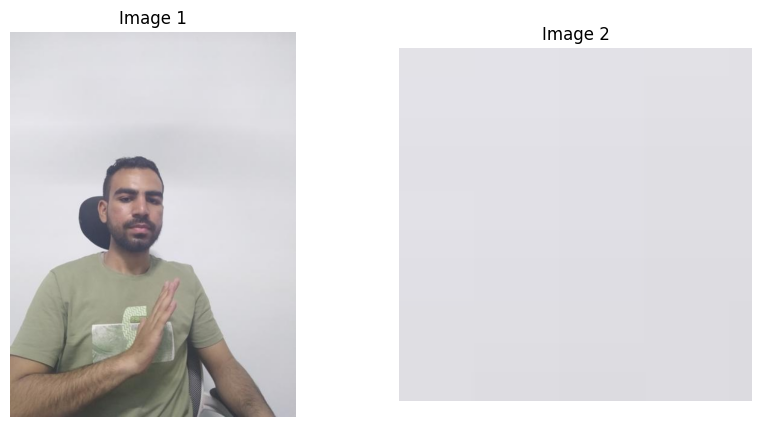

In [ ]:

# Load pre-trained hand detection model (e.g., Faster R-CNN)
hand_detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
hand_detection_model.eval()

# Function to extract hand region and resize
def extract_hand_region(image_path):
    # Load the image
    img = Image.open(image_path)

    # Apply transformations for hand detection model
    transform_detection = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform_detection(img)

    # Perform hand detection
    with torch.no_grad():
        prediction = hand_detection_model([img_tensor])
    boxes = prediction[0]['boxes']
    confidences = prediction[0]['scores']
    print(boxes)
    print(confidences)
    # Assuming one hand is detected
    hand_box = boxes[-1].cpu().numpy().astype(int)
    x_min, y_min, x_max, y_max = hand_box
    print(hand_box)

    # Crop the image to the hand region
    cropped_img = F.crop(img, y_min, x_min, y_max - y_min, x_max - x_min)

    # Resize the cropped image to 224x224 (size expected by ResNet18)
    resized_img = F.resize(cropped_img, (224, 224))

    return resized_img

def pre_process_img(img_path, transform):
    hand_region = extract_hand_region(img_path)
    hand_region = transform(hand_region)
    return hand_region

# Define dataset class
class SignLanguageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.data = datasets.ImageFolder(root_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, _ = self.data.imgs[idx]
        label = self.data.targets[idx]
        hand_region = pre_process_img(img_path, self.transform)
        return hand_region, label


def visualize_images(image1, image2):

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the first image
    axes[0].imshow(image1)
    axes[0].set_title('Image 1')
    axes[0].axis('off')  # Hide axis for the first image

    # Display the second image
    axes[1].imshow(image2)
    axes[1].set_title('Image 2')
    axes[1].axis('off')  # Hide axis for the second image

    plt.show()

img = Image.open("data/visualize.jpg")
hand = extract_hand_region("data/visualize.jpg")
visualize_images(img, hand)

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
data = SignLanguageDataset('data/', transform=transform)
print(len(data))

# Split dataset into train and validation
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)

663


In [ ]:
# Load pre-trained model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
num_epochs = 45
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, num_epochs, val_loss/len(val_loader), 100 * correct / total))


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model_params.pth')